# Transformers with TensorFlow

The original version of this notebook - https://colab.research.google.com/drive/1er3eOUILQ5MOB2Uzh1lntiDiK92DfvO4?usp=sharing



In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-760c813f-3b88-d852-4fbd-8041c5734361)


In [ ]:
!pip -q install transformers

     |████████████████████████████████| 5.5 MB 5.1 MB/s 
     |████████████████████████████████| 182 kB 54.8 MB/s 
     |████████████████████████████████| 7.6 MB 43.5 MB/s 


In [ ]:
# 2 Classes 
!wget -q https://www.dropbox.com/s/ma7aik3z7dbj4gg/meet_reviews_03.csv

# 5 class based on the 5 stars - try later
# !wget -q https://www.dropbox.com/s/gxjn9yqa6nd3ob1/meet_reviews_02.csv

2 Main parts:
- Tokenizer 
- Model

In [ ]:
# imports 
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification #thTFAutoModelForSequenceClassificationis is a head
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
ls

meet_reviews_03.csv  sample_data/


## Load up some App Reviews

In [ ]:
# load data into a dataframe
df = pd.read_csv('meet_reviews_03.csv', encoding='utf-8', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# lets look at the shape of the data
df.shape

(3898, 3)

In [ ]:

df.head()

,Unnamed: 0,content,score
0,0,Firstly i like this app very so much. But afte...,1
1,1,The reason behind giving only one star is the ...,1
2,2,Although this app is good but still i hate it....,1
3,3,Can't access any settings within this app from...,1
4,4,I have online classes I can't hear it nicely i...,1


In [ ]:
df.tail()

,Unnamed: 0,content,score
3893,5293,Nice app,5
3894,5294,😡😡😡😡😡.,5
3895,5295,Thank you for this app,5
3896,5296,👌,5
3897,5297,Wow,5


In [ ]:
df['score'].unique()

array([1, 5])

In [ ]:
# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

train_df = df[:3600][['content','score']]
valid_df = df[3600:][['content','score']]


In [ ]:
train_df.shape

(3600, 2)

In [ ]:
valid_df.shape

(298, 2)

## Plot out some info

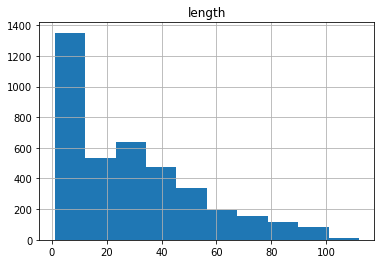

In [ ]:
# review lengths
df['length'] = df['content'].apply(lambda x: len(x.split(' ')))

df.hist("length", bins=10);

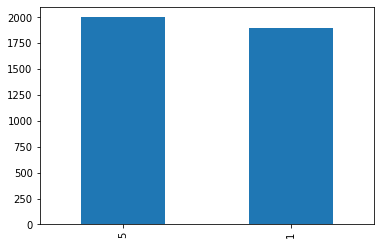

In [ ]:
# checking amounts for each class
df['score'].value_counts().plot(kind='bar')

## Load the Model and Tokenizer

1.

In [ ]:
# What model will we use?
model_name = 'bert-base-cased' #Can read both upper and lower case. This name willtell AUtoTokenizer which model to fetch #Roberta by FB

# Load a tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Load the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Different cases different tokens and if no token present it will be subword.

In [ ]:
tokenizer.tokenize('Tonight we are at the Women who code event')

['Tonight', 'we', 'are', 'at', 'the', 'Women', 'who', 'code', 'event']

In [ ]:
tokenizer.tokenize('tonight we are at the Women who code event')

['tonight', 'we', 'are', 'at', 'the', 'Women', 'who', 'code', 'event']

In [ ]:
tokenizer.tokenize('Tonight we are at the Women who code event in Lusail')

['Tonight',
 'we',
 'are',
 'at',
 'the',
 'Women',
 'who',
 'code',
 'event',
 'in',
 'Lu',
 '##sai',
 '##l']

In [ ]:
tokenizer.tokenize('Tonight we are at the Women who code event in Lusail with J.K.Rowling')

['Tonight',
 'we',
 'are',
 'at',
 'the',
 'Women',
 'who',
 'code',
 'event',
 'in',
 'Lu',
 '##sai',
 '##l',
 'with',
 'J',
 '.',
 'K',
 '.',
 'Row',
 '##ling']

#### Preparing the text

We need to get the text into a format so that we can pass it into the tokenizer

In [ ]:
train_texts = train_df['content'].tolist()
valid_texts = valid_df['content'].tolist()

print(len(train_texts))
train_texts[:5]

3600


["Can't download this app.what is reason..?",
 'I like this app very most🥰 in case of low net it is very clear😄. Thank you google making this app🥰',
 'Heenakausar',
 'I cannot change my wallpaper',
 "I can't use the microphone because it's easily damaged and takes time to repair. In fact, this app doesn't allow me to enter my class at a very important time. While I don't have to use a back pattern. This app keeps removing my face with a back pattern and I don’t want a pattern on my back. This app is inadequate also very not fully functional.Because I gave it 2 stars because I am not satisfied with the service provided by the Google Meet app."]

## Tokenizing, Padding and Truncating the text

In [ ]:
from pandas.core.computation.parsing import tokenize
# Pad the tokenizer outputs to the same length for all samples

# tokenize the training data
train_tokens = tokenizer(train_texts, max_length=128, truncation=True, padding='max_length', add_special_tokens=True, return_token_type_ids=False, return_tensors='tf')


# tokenize the validation data
valid_tokens = tokenizer(valid_texts, max_length=128, truncation=True, padding='max_length', add_special_tokens=True, return_token_type_ids=False, return_tensors='tf')



In [ ]:
# Lets look at the tokens
tokenizer.special_tokens_map, tokenizer.cls_token_id, tokenizer.sep_token_id

({'unk_token': '[UNK]',
  'sep_token': '[SEP]',
  'pad_token': '[PAD]',
  'cls_token': '[CLS]',
  'mask_token': '[MASK]'},
 101,
 102)

In [ ]:
# what did the tokenizer make?
train_tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
# input_ids 
train_tokens['input_ids'][0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  2825,   112,   189,  9133,  1142, 12647,   119,  1184,
        1110,  2255,   119,   119,   136,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [ ]:
# Attention masks
train_tokens['attention_mask'][0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

### Creating the Labels

In [ ]:
# map the labels 
label_map = {1:0, 5:1}
label_map

{1: 0, 5: 1}

In [ ]:
# Map the labels to our dictionary
train_labels = train_df['score'].map(label_map).values
valid_labels = valid_df['score'].map(label_map).values

In [ ]:
# Lets check that 
row = 500

train_df['score'].iloc[row], train_labels[row]

(5, 1)

## Setting up the model

In [ ]:
# optimizer
opt = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)

In [ ]:
#loss
loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# compile the model
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])


In [ ]:
# lets look at the model
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# lets freeze the bert layer
model.layers[0].trainable=False #We can pass things trought it butweights are not updated

In [ ]:
# lets look at the model again
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 1,538
Non-trainable params: 108,310,272
_________________________________________________________________


### Training

In [ ]:
# train the model
model.fit(dict(train_tokens), train_labels, epochs=3, batch_size=16, validation_data=(dict(valid_tokens), valid_labels), verbose=1)

Epoch 1/3
225/225 [==============================] - 110s 423ms/step - loss: 0.5420 - accuracy: 0.7328 - val_loss: 0.4605 - val_accuracy: 0.8255
Epoch 2/3
225/225 [==============================] - 93s 412ms/step - loss: 0.4008 - accuracy: 0.8336 - val_loss: 0.4669 - val_accuracy: 0.7953
Epoch 3/3
225/225 [==============================] - 93s 414ms/step - loss: 0.2953 - accuracy: 0.8869 - val_loss: 0.4604 - val_accuracy: 0.8188


In [ ]:
model.evaluate(dict(valid_tokens), valid_labels)

10/10 [==============================] - 3s 252ms/step - loss: 0.4604 - accuracy: 0.8188


[0.4603744149208069, 0.818791925907135]

## Predictions

In [ ]:
review = 'This app is pretty cool and has lots of good features'
# review = 'This app is pretty bad and has lots of awful features'



In [ ]:
review_tokens = tokenizer([review], max_length=128, truncation=True, padding='max_length', add_special_tokens=True, return_token_type_ids=False, return_tensors='tf')

In [ ]:
review_tokens

{'input_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  1188, 12647,  1110,  2785,  4348,  1105,  1144,  7424,
         1104,  1363,  1956,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [ ]:
# PREDICTION 
pred = model.predict(dict(review_tokens))[0]

print(pred)

pred = tf.keras.activations.softmax(tf.constant(pred)).numpy()
pred

1/1 [==============================] - 0s 72ms/step
[[-1.8706787  1.1692321]]


array([[0.04565506, 0.9543449 ]], dtype=float32)

In [ ]:
# argmax out the result
np.argmax(pred, axis=-1)

array([1])

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 1,538
Non-trainable params: 108,310,272
_________________________________________________________________


In [ ]:
def get_model_layers(model):
    layers_temp = []
    layers = []
    weights = []
    params_total = 0
    for layer in model.layers:
        type_name = type(layer).__name__
        print(layer.name, type_name, layer.count_params())
        for i,sub in enumerate(layer.submodules):
            if sub.built:
                print(i+1, type(sub).__name__, sub.trainable, sub.count_params())
        # add params
        params_total += layer.count_params()

        #get the weights
        layer_wb = layer.get_weights()
        weights.append(layer_wb)

        # the raw weights
        layers_temp.append(layer)
    print(len(layers_temp))
    return layers,layers_temp, params_total

get_model_layers(model)

bert TFBertMainLayer 108310272
1 TFBertEmbeddings False 22665216
2 TFBertEncoder False 85054464
3 TFBertPooler False 590592
4 LayerNormalization False 1536
5 Dropout False 0
6 TFBertLayer False 7087872
7 TFBertLayer False 7087872
8 TFBertLayer False 7087872
9 TFBertLayer False 7087872
10 TFBertLayer False 7087872
11 TFBertLayer False 7087872
12 TFBertLayer False 7087872
13 TFBertLayer False 7087872
14 TFBertLayer False 7087872
15 TFBertLayer False 7087872
16 TFBertLayer False 7087872
17 TFBertLayer False 7087872
18 TFBertAttention False 2363904
19 TFBertIntermediate False 2362368
20 TFBertOutput False 2361600
21 TFBertSelfAttention False 1771776
22 TFBertSelfOutput False 592128
23 Dense False 590592
24 Dense False 590592
25 Dense False 590592
26 Dropout False 0
27 LayerNormalization False 1536
28 Dense False 590592
29 Dropout False 0
30 Dense False 2362368
31 LayerNormalization False 1536
32 Dense False 2360064
33 Dropout False 0
34 TFBertAttention False 2363904
35 TFBertIntermediate F

([],
 108311810)